In [69]:
data_path_org = "C:/Thesis/Scripts/vlasov_ngo_data_with_initial.npz"
data_path = "C:/Thesis/Scripts/vlasov_ngo_data_extended_time.npz"

import torch
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch import nn, optim, utils
from torch.utils.data import Dataset, DataLoader, random_split
import opt_einsum

class PDEDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        params = data['params']
        initial_conditions = data['initial_conditions']    
        solutions = data['solutions'] 
        
        self.x = torch.from_numpy(params).float()
        
        # Handle complex-valued solutions
        if np.iscomplexobj(solutions):
            if solutions.ndim == 3:
                solutions = solutions.reshape(solutions.shape[0], -1)
            
            self.y = torch.complex(
                torch.from_numpy(solutions.real).float(),
                torch.from_numpy(solutions.imag).float()
            )
        else: #back-up for some weird case were data would not be complex
            self.y = torch.from_numpy(solutions).float()
            if self.y.ndim == 5:
                self.y = self.y.view(self.y.size(0), -1)

        if np.iscomplexobj(initial_conditions):
            if initial_conditions.ndim == 3:
                initial_conditions = initial_conditions.reshape(initial_conditions.shape[0], -1)

            self.z = torch.complex(
                torch.from_numpy(initial_conditions.real).float(),
                torch.from_numpy(initial_conditions.imag).float()
            )
        
        assert self.x.shape[0] == self.y.shape[0] ==self.z.shape[0], \
            f"Mismatch: inputs {self.x.shape[0]} vs outputs {self.y.shape[0]}"
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx], self.y[idx]

def integrate(W, values):
    """
    Values shape: (Batch, Time, Velocity) -> (B, 3, 32)
    W shape: (Velocity,) -> (32,)
    Returns: (Batch, Time)
    """
    # Simple trapezoidal-style integration or weighted sum
    # We sum over the last dimension (velocity)
    return torch.sum(values * W, dim=-1)


dataset = np.load(data_path)
full_dataset_test = PDEDataset(data_path)
# 1. Check how many samples the Dataset thinks it has
print(f"Dataset length: {len(full_dataset_test)}") 

# 2. Check the shapes of the actual tensors stored inside the class
print(f"Inputs shape: {full_dataset_test.x.shape}")
print(full_dataset_test.z.shape)
print(f"Solutions shape: {full_dataset_test.y.shape}")

# 3. Check the keys inside the .npz file
print(f"Keys in .npz: {dataset.files}")

import torch
import lightning as L

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Dataset length: 10000
Inputs shape: torch.Size([10000, 4])
torch.Size([10000, 32])
Solutions shape: torch.Size([10000, 256])
Keys in .npz: ['params', 'initial_conditions', 'solutions']
PyTorch version: 2.5.1+cu121
CUDA available: True
GPU Name: Quadro T1000 with Max-Q Design


In [70]:
class VlasovModel(L.LightningModule):
    def __init__(self, input_dim=4, output_dim=256,Nv=32,Nt=8):
        super().__init__()
        self.output_dim = output_dim
        self.Nt = Nt
        self.Nv = Nv
        initiial_size = Nv * 2
        total_input = input_dim + initiial_size
        self.model = nn.Sequential(
            nn.Linear(total_input, 512),  # Increased for complex output
            nn.ReLU(),
            nn.Linear(512, 1028),
            nn.ReLU(),
            nn.Linear(1028, self.output_dim * 2)  # *2 for real and imaginary parts
        )
        # self.model = nn.Sequential(
        #     nn.Linear(input_dim, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 1024),
        #     nn.ReLU(),
        #     # Output is total_elements * 2 (for real and imaginary)
        #     nn.Linear(1024, self.output_dim * 2)
        # )
        self.loss_fn = nn.MSELoss()
    
    # def forward(self, x):
    #     out = self.model(x)
    #     # Split into real and imaginary parts
    #     real = out[..., :self.output_dim]
    #     imag = out[..., self.output_dim:]
    #     # Combine into complex tensor
    #     return torch.complex(real, imag)
    def forward(self, params, initial_conditions):
        batch_size = params.shape[0]
        
        # Flatten forcing and split real/imag
        init_flat = initial_conditions.view(batch_size, -1)  # (batch, Nt*Nv)
        init_real_imag = torch.cat([init_flat.real, init_flat.imag], dim=1)
        
        # Concatenate params and forcing
        x = torch.cat([params, init_real_imag], dim=1)
        
        # Forward pass
        out = self.model(x)
        
        # Split into real and imaginary
        real = out[..., :self.output_dim]
        imag = out[..., self.output_dim:]
        
        return torch.complex(real, imag)
    
    # def training_step(self, batch, batch_idx):
    #     x, y = batch  # y should be complex tensor
    #     preds = self(x)
    #     # Compute loss on both real and imaginary parts
    #     loss = self.loss_fn(preds.real, y.real) + self.loss_fn(preds.imag, y.imag)
    #     self.log("train_loss", loss)
    #     return loss
    
    # def training_step(self, batch, batch_idx):
    #     params, initial_conditions, solution = batch
    #     preds = self(params, initial_conditions)
    #     # Compute loss on both real and imaginary parts
    #     loss = self.loss_fn(preds.real, solution.real) + self.loss_fn(preds.imag, solution.imag)
    #     self.log("train_loss", loss)
    #     return loss

    def training_step(self, batch, batch_idx):
        params, initial_conditions, solution = batch
        preds = self(params, initial_conditions)

        # 1. Reshape to (Batch, Time, Velocity)
        # This is necessary for the integrate() function to work on the right dims
        y_hat = preds.view(-1, 8, 32)
        y_true = solution.view(-1, 8, 32)

        # 2. Define Weights (W)
        # If your velocity grid is uniform from -4 to 4 with 32 points:
        # dv = (4 - (-4)) / (32 - 1)
        W = torch.ones(32, device=self.device) # You can replace with actual integration weights

        # 3. Compute Complex Relative L2 Norm
        # We apply the logic of your 'relativeL2norm_set' but for complex values
        diff_sq = (y_hat.real - y_true.real)**2 + (y_hat.imag - y_true.imag)**2
        true_sq = y_true.real**2 + y_true.imag**2

        # Using the integration logic from your snippets
        # Note: ensure your integrate() function is defined in your scope
        l2_diff = integrate(W, diff_sq)**(0.5)
        l2_norm = integrate(W, true_sq)**(0.5)
        
        # Calculate relative error and average over the batch
        loss = torch.mean(l2_diff / torch.clamp(l2_norm, min=1e-7))

        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        params, initial_conditions, solution = batch
        preds = self(params, initial_conditions)
        val_loss = self.loss_fn(preds.real, solution.real) + self.loss_fn(preds.imag, solution.imag)
        self.log("val_loss", val_loss, prog_bar=True)
        return val_loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode  | FLOPs
-------------------------------------------------------
0 | model   | Sequential | 1.1 M  | train | 0    
1 | loss_fn | MSELoss    | 0      | train | 0    
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.358     Total estimated model params size (MB)
7         Modules in train mode
0         Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\20213341\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


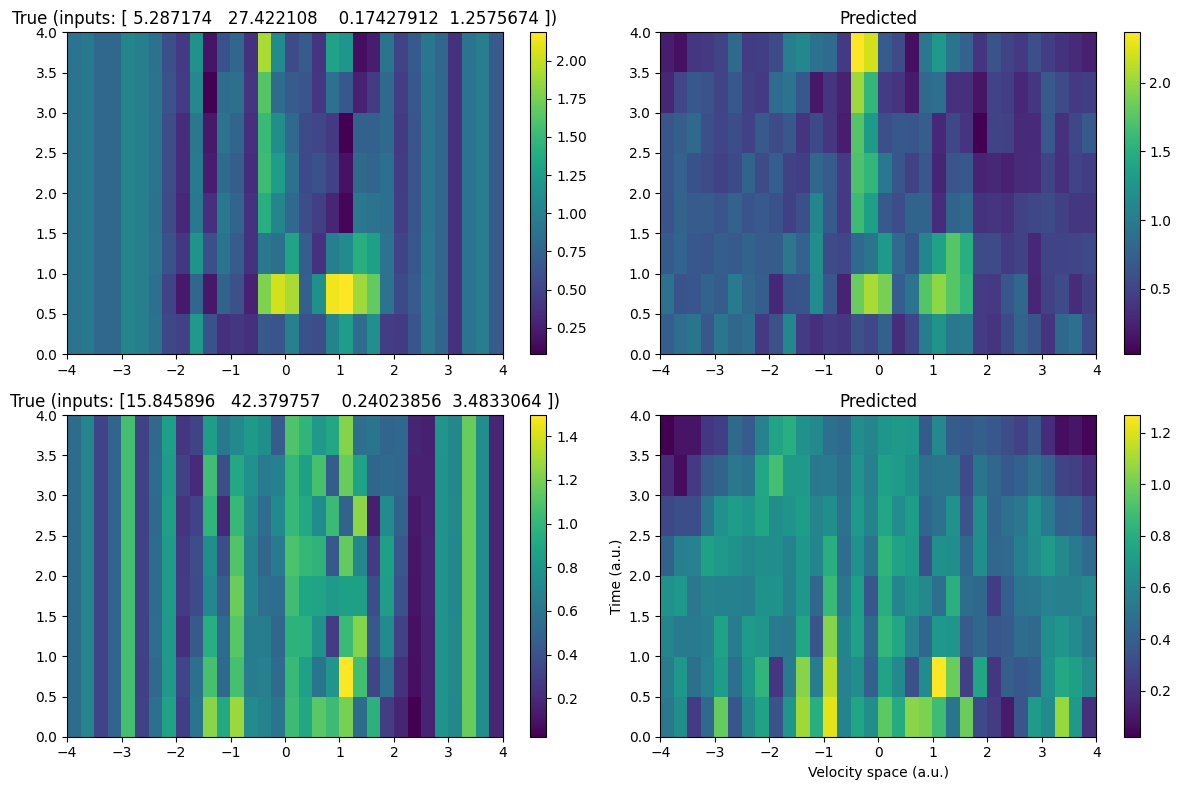

In [82]:
# --- 3. Execution Block ---
if __name__ == "__main__":
    # 1. Load and Split Data
    full_dataset = PDEDataset(data_path)
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32)
    
    # 2. Initialize Model
    model = VlasovModel(input_dim=4, output_dim=256, Nt=8,Nv=32)  # Changed from 1 to 96
    
    # 3. Train
    trainer = L.Trainer(max_epochs=50, accelerator="auto")
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
# --- Compare several validation samples ---
model.eval()

num_samples = 2
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))

for i in range(num_samples):
    params, initial_cond, solution = val_set[i]

    # Predict
    with torch.no_grad():
        y_pred = model(params.unsqueeze(0), initial_cond.unsqueeze(0)).squeeze(0)

    # Plot
    true_grid = solution.view(8, 32).abs().numpy()
    pred_grid = y_pred.view(8, 32).abs().numpy()

    t_min, t_max = 0.0, 4.0
    v_min, v_max = -4, 4 
    plot_extent = [v_min, v_max, t_min, t_max]

    im1 = axes[i, 0].imshow(true_grid, aspect='auto',extent = plot_extent, origin = 'lower')
    axes[i, 0].set_title(f"True (inputs: {params.numpy()})")
    plt.colorbar(im1, ax=axes[i, 0])
    plt.xlabel("Velocity space (a.u.)")
    plt.ylabel("Time (a.u.)")
    
    im2 = axes[i, 1].imshow(pred_grid, aspect='auto',extent = plot_extent, origin = 'lower')
    axes[i, 1].set_title(f"Predicted")
    plt.colorbar(im2, ax=axes[i, 1])
    plt.xlabel("Velocity space (a.u.)")
    plt.ylabel("Time (a.u.)")

plt.tight_layout()
plt.show()

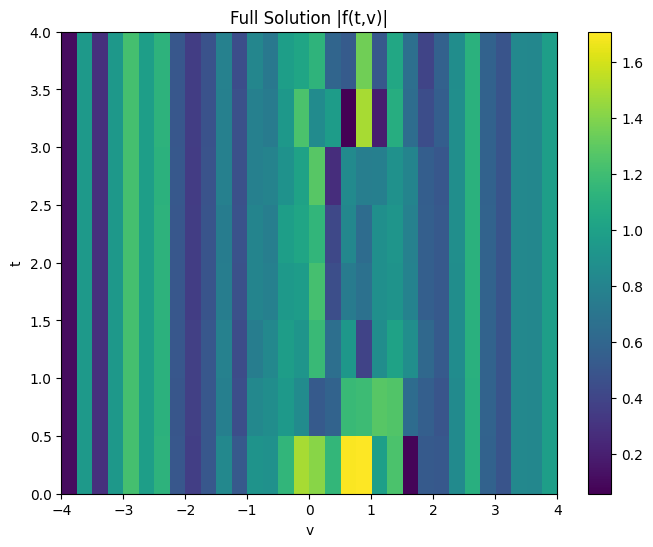

Estimated Dominant Growth Rate (gamma): -0.0268


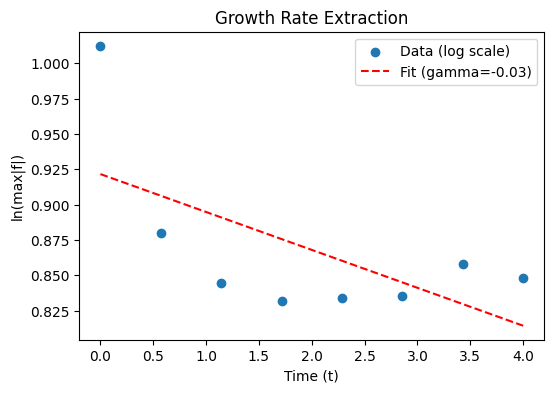

In [86]:
model.eval()

# Create input parameters as tensor with batch dimension
params_custom = torch.tensor([[5.0, 40.0, 0.3, 1.0]], dtype=torch.float32)  # Shape: (1, 4)

Nt = 8
Nv = 32
v = np.linspace(-4,4,Nv)
# Create zero forcing with batch dimension
initial_perurbation = 0.001 * np.exp(-v**2 / 2) / np.sqrt(2 * np.pi)  # Shape: (1, 16, 32)
initial_condition = torch.from_numpy(initial_perurbation).to(torch.complex64)

params, initial_cond, solution_from_data = val_set[80]

with torch.no_grad():
    solution_prediction = model(params_custom, initial_condition)  # Shape: (1, 512)

# Plot the solution
grid_2 = solution_prediction[0].view(8, 32).abs().cpu().numpy()  # [0] removes batch dim
grid = solution_from_data.view(8, 32).abs().numpy() # this line can be changed into solution_prediction too

t_min, t_max = 0.0, 4.0
v_min, v_max = -4, 4 
plot_extent = [v_min, v_max, t_min, t_max]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(grid, aspect='auto', cmap='viridis',extent=plot_extent,origin='lower')
ax.set_title("Full Solution |f(t,v)|")
ax.set_xlabel("v")
ax.set_ylabel("t")
plt.colorbar(im, ax=ax)
plt.show()

import numpy as np
dv = v[1] - v[0]

# 1. Define the time vector
times = np.linspace(t_min, t_max, Nt)  # [0.0, 0.15, 0.3]

# 2. Calculate the "Amplitude" at each time step
# We use the maximum value of |f| across velocity space for each time
amplitudes_2 =  np.max(grid,axis=1)
# Calculate L2 norm across the velocity space (axis 1)
amplitudes = np.sqrt(np.sum(np.abs(grid)**2, axis=1) * dv)

# 3. Perform a linear fit to the logarithm of the amplitudes
# ln(A) = slope * t + intercept -> slope is our gamma
log_amps = np.log(amplitudes + 1e-12) # Added epsilon to avoid log(0)
slope, intercept = np.polyfit(times, log_amps, 1)

print(f"Estimated Dominant Growth Rate (gamma): {slope:.4f}")

# Optional: Visualize the fit
plt.figure(figsize=(6, 4))
plt.scatter(times, log_amps, label='Data (log scale)')
plt.plot(times, slope*times + intercept, color='red', linestyle='--', label=f'Fit (gamma={slope:.2f})')
plt.xlabel("Time (t)")
plt.ylabel("ln(max|f|)")
plt.legend()
plt.title("Growth Rate Extraction")
plt.show()

In [66]:
import numpy as np
from scipy.linalg import eig

# 1. Setup specific test parameters (matching your params_custom)
omega_n, omega_Ti, ky, kz = 2.0, 20.0, 0.4, 3.0
t_test = np.linspace(0.0, 0.3, 3) # Nt=3 as in your prediction
v_test = np.linspace(-4, 4, 32)
dv = v_test[1] - v_test[0]

# 2. Reconstruct Operator A
v_matrix = np.diag(v_test)
F0 = (1.0 / np.pi**0.5) * np.exp(-v_test**2)
Integral_Operator = np.diag(F0) @ (np.ones((32, 32)) * dv)
bracket_term = omega_n + (v_test**2 - 0.5) * omega_Ti
A = -1j*kz*v_matrix - 1j*kz*(v_matrix @ Integral_Operator) - 1j*ky*(np.diag(bracket_term) @ Integral_Operator)

# 3. Solve Eigenproblem
evals, evecs = eig(A)

# 4. Use the same coefficients logic as your training data
# Note: If you want to match a specific initial condition, 
# you'd solve: coeffs = np.linalg.solve(evecs, initial_condition)
np.random.seed(42) # For reproducibility
c_i = np.random.uniform(0.01, 1.0, size=32) + 1j * np.random.uniform(0.01, 1.0, size=32)
initial_perturbation = 0.001 * np.exp(-v**2 / 2) / np.sqrt(2 * np.pi)


# 5. Generate "Ground Truth" Solution
time_evol = np.exp(np.outer(t_test, evals))
true_solution = np.einsum('tj, j, vj -> tv', time_evol, initial_perturbation, evecs)

# 6. Extraction Check
true_grid = np.abs(true_solution)
amps = np.sqrt(np.sum(np.square(grid), axis=1)) #np.max(true_grid, axis=1)
log_amps = np.log(amps + 1e-12)
slope, _ = np.polyfit(t_test, log_amps, 1)

# 7. Compare with Physics
actual_max_gamma = np.max(evals.real)

print(f"--- Verification ---")
print(f"Theoretical Max Gamma (from Eigenvalues): {actual_max_gamma:.4f}")
print(f"Extracted Gamma (from 3-point fit):      {slope:.4f}")
print(f"Difference: {abs(actual_max_gamma - slope):.4f}")

TypeError: expected x and y to have same length

In [91]:
import numpy as np
from scipy.linalg import eig, solve
import matplotlib.pyplot as plt

# --- 1. Parameters (Updated for longer time) ---
omega_n, omega_Ti, ky, kz = 2.3, 24, 0.3, 1.0
t_max = 4.0  # Extended time
Nt = 8     # More steps
t_test = np.linspace(0.0, t_max, Nt)
v_test = np.linspace(-4, 4, 32)
dv = v_test[1] - v_test[0]

# --- 2. Reconstruct Operator A ---
v_matrix = np.diag(v_test)
F0 = (1.0 / np.sqrt(np.pi)) * np.exp(-v_test**2)
# Ensure the integral operator is correctly weighted by dv
Integral_Operator = np.diag(F0) @ (np.ones((32, 32)) * dv)
bracket_term = omega_n + (v_test**2 - 0.5) * omega_Ti
A = -1j*kz*v_matrix - 1j*kz*(v_matrix @ Integral_Operator) - 1j*ky*(np.diag(bracket_term) @ Integral_Operator)

# --- 3. Solve Eigenproblem ---
evals, evecs = eig(A)

params, initial_cond, solution_check_blah = val_set[80]

solution_numpy = solution_check_blah.numpy()
print(solution_check_blah)

# --- 4. Projection of Initial Condition ---
# We want: f(0, v) = Sum(c_i * evec_i). This is a linear system: V * c = f_0
initial_perturbation = 0.001 * np.exp(-v_test**2 / 2) / np.sqrt(2 * np.pi)
coeffs = solve(evecs, initial_perturbation) # Find the c_i for this specific Gaussian

# --- 5. Generate Ground Truth Solution ---
time_evol = np.exp(np.outer(t_test, evals))
# Summing modes: sum over j (eigenmodes) of [exp(lambda_j * t) * c_j * eigenvector_j]
true_solution = np.einsum('tj, j, vj -> tv', time_evol, coeffs, evecs)

# --- 6. Extraction Check (L2 Norm) ---
# We use the absolute magnitude squared for complex solutions
amps = np.sqrt(np.sum(np.abs(solution_numpy)**2, axis=1) * dv)
log_amps = np.log(amps + 1e-12)

# Linear fit
slope, intercept = np.polyfit(t_test, log_amps, 1)
actual_max_gamma = np.max(evals.real)

# --- 7. Output Results ---
print(f"--- Verification at t={t_max} ---")
print(f"Theoretical Max Gamma: {actual_max_gamma:.4f}")
print(f"Extracted Gamma:       {slope:.4f}")
print(f"Error:                 {abs(actual_max_gamma - slope):.4f}")

# Visualizing the log-growth
plt.figure(figsize=(6, 4))
plt.plot(t_test, log_amps, 'o-', label='$\ln ||f||_2$')
plt.plot(t_test, slope*t_test + intercept, '--', label=f'Fit ($\gamma$={slope:.2f})')
plt.title(f"Growth Extraction ($t_{{max}}={t_max}$)")
plt.xlabel("Time")
plt.ylabel("log(Amplitude)")
plt.legend()
plt.grid(True)
plt.show()

tensor([ 0.0915+0.0648j,  0.3711+0.8757j,  0.2665+0.1004j,  0.7388+0.5751j,
         0.9864+0.7222j,  0.7570+0.6287j,  0.9095+0.6552j,  0.4020+0.3085j,
         0.3442+0.1112j,  0.4409+0.2459j,  0.1698+0.8119j,  0.1885+0.4838j,
         0.5336+0.7303j,  0.8867+0.1210j,  1.0142+0.5320j,  0.6665+1.3360j,
         0.8845+1.0993j,  0.4602+1.0559j,  1.1421+1.2584j,  0.9796+1.3972j,
         0.6156+0.7746j,  0.8770+0.8778j, -0.0632+0.0531j,  0.3474+0.3922j,
         0.2778+0.4278j,  0.4667+0.7098j,  0.8190+0.7270j,  0.5761+0.0335j,
         0.4680+0.1268j,  0.6074+0.5660j,  0.8213+0.0650j,  0.6434+0.7436j,
        -0.0069+0.1119j, -0.1367+0.9412j,  0.2583+0.1198j,  0.9036+0.2447j,
         1.1880-0.2861j,  0.7832-0.5930j,  0.4133-1.0386j, -0.0462-0.4989j,
        -0.3042-0.2076j, -0.4839-0.1529j, -0.5651-0.5201j, -0.4547-0.0135j,
        -0.6586+0.5034j,  0.3783+0.7826j,  0.5569+0.7644j,  0.2630+0.8137j,
         0.5162-0.1054j, -0.3310-0.4814j, -0.3851-1.1094j, -0.7501-0.9227j,
        -1.2

AxisError: axis 1 is out of bounds for array of dimension 1

In [1]:
def extract_dominant_mode(model, input_params):
    """
    Extract the dominant eigenmode from model prediction.
    
    Args:
        model: Trained neural network
        input_params: Array or tensor of 4 input values
    
    Returns:
        eigenvalue: Complex number (growth rate + i*frequency)
        eigenvector: Complex array of shape (32,) - the spatial pattern
    """
    model.eval()
    
    # 1. Get prediction from model
    if not torch.is_tensor(input_params):
        input_params = torch.tensor(input_params, dtype=torch.float32)
    if input_params.dim() == 1:
        input_params = input_params.unsqueeze(0)
    
    with torch.no_grad():
        solution = model(input_params)  # Shape: (1, 96) complex
    
    # 2. Reshape to (3 time, 32 space)
    solution = solution.squeeze(0).view(5, 32).cpu().numpy()
    
    # 3. SVD to find dominant spatial pattern
    U, S, Vh = np.linalg.svd(solution, full_matrices=False)
    # Vh[0] is the dominant eigenvector (spatial pattern)
    eigenvector = Vh[0]  # Shape: (32,)
    
    # 4. Estimate eigenvalue from time evolution
    # The dominant mode evolves as: amplitude * exp(λ * t)
    t = np.array([0.0, 0.125, 0.25, 0.375, 0.5])  # YOUR ACTUAL TIME VALUES HERE
    mode_amplitude = U[:, 0] * S[0]  # How this mode evolves in time
    
    # Estimate λ from two consecutive time points
    eigenvalue = np.log(mode_amplitude[1] / mode_amplitude[0]) / (t[1] - t[0])
    
    return eigenvalue, eigenvector


# Usage:
if __name__ == "__main__":
    # ... after training ...
    
    # Test with specific input parameters
    test_params = [5.0, 40.0, 0.3, 3.0]  # Your 4 input values
    
    eigenvalue, eigenvector = extract_dominant_mode(model, test_params)
    
    print("Dominant Eigenmode:")
    print(f"  Eigenvalue: {eigenvalue}")
    print(f"  Growth rate: {eigenvalue.real:.4f}")
    print(f"  Frequency: {eigenvalue.imag:.4f}")
    
    # Visualize the eigenvector
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.abs(eigenvector))
    plt.title("Eigenvector Magnitude")
    plt.xlabel("Velocity Grid Point")
    plt.ylabel("Amplitude")
    
    plt.subplot(1, 2, 2)
    plt.plot(np.angle(eigenvector))
    plt.title("Eigenvector Phase")
    plt.xlabel("Velocity Grid Point")
    plt.ylabel("Phase (radians)")
    
    plt.tight_layout()
    plt.show()

NameError: name 'model' is not defined